In [2]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
from google.colab import drive


In [3]:
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
#tf.device('/device:GPU:0')
#Change runtime to GPU

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
num_bounding_box_to_predict = 4
#image (720, 1280, 3)
desired_shape = (1280,720)


In [ ]:
def create_mlp_model(image_height, image_width, num_channels, dense_layer_list = []):
    model = keras.Sequential()

    model.add(layers.Flatten(input_shape=(image_height, image_width, num_channels)) )
    for num_nodes in dense_layer_list:
      model.add(layers.Dense(num_nodes, activation='relu'))

    model.add(layers.Dense(num_bounding_box_to_predict*4, activation='linear'))

    return model

In [6]:
def create_cnn_model( image_width, image_height, num_channels, dense_layer_list = [], num_con_layers = 1, num_pooling_layers = 1):
    model = keras.Sequential()

    model.add(layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu', input_shape = ( image_width, image_height, num_channels)))
    model.add(layers.MaxPooling2D(pool_size = (2,2 ), strides = (1,1)))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu'))
    model.add(layers.MaxPooling2D(pool_size = (2,2 ), strides = (1,1)))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (2,2), padding = 'valid', activation = 'relu'))
    model.add(layers.MaxPooling2D(pool_size = (2,2 ), strides = (2,2)))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (2,2), padding = 'valid', activation = 'relu'))
    model.add(layers.MaxPooling2D(pool_size = (2,2 ), strides = (2,2)))
    model.add(layers.Dropout(0.4))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    #model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(num_bounding_box_to_predict*4, activation='linear'))


    return model

In [7]:
def load_data(folder_path, num_images_to_load, num_bounding_box_to_predict, desired_shape):
    image_folder_path = os.path.join(folder_path, "images")
    annotation_folder_path = os.path.join(folder_path, "annotations")
    image_files = os.listdir(image_folder_path)
    num_images = min(len(image_files), num_images_to_load)

    images = []
    bounding_boxes = []

    for i in range(num_images):

        if "(" in image_files[i]:
          continue

        image_path = os.path.join(image_folder_path, image_files[i])
        img = cv2.imread(image_path)
        img = cv2.resize(img, desired_shape, interpolation=cv2.INTER_AREA)
        images.append(img)

        xml_file = image_files[i].replace(".jpg", ".xml")
        xml_path = os.path.join(annotation_folder_path, xml_file)
        tree = ET.parse(xml_path)
        root = tree.getroot()
        image_bounding_box = []

        for obj in root.findall(".//object[name='bottle']"):
            xmin = int(obj.find("bndbox/xmin").text)
            ymin = int(obj.find("bndbox/ymin").text)
            xmax = int(obj.find("bndbox/xmax").text)
            ymax = int(obj.find("bndbox/ymax").text)
            image_bounding_box.extend([xmin, ymin, xmax, ymax])

            if len(image_bounding_box) >= (num_bounding_box_to_predict * 4):
                break

        if len(image_bounding_box) < (num_bounding_box_to_predict * 4):
            image_bounding_box.extend([0, 0, 0, 0] * (num_bounding_box_to_predict - len(image_bounding_box) // 4))

        bounding_boxes.append(image_bounding_box)

    return np.array(images), np.array(bounding_boxes)

In [8]:
training_folder_path = "drive/MyDrive/FloW_IMG/FloW_IMG/training"
training_images, training_bounding_boxes = load_data(training_folder_path, 600, num_bounding_box_to_predict, desired_shape)

training_images = np.array(training_images)
training_bounding_boxes = np.array(training_bounding_boxes)
training_images = np.reshape(training_images, (-1, 1280, 720, 3))

# MLP model

In [ ]:
model = create_mlp_model(720, 1280, 3, [64, 32])
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(training_images, training_bounding_boxes, epochs=20, verbose=1, validation_split = 0.2, batch_size = 256)

Epoch 1/20


KeyboardInterrupt: ignored

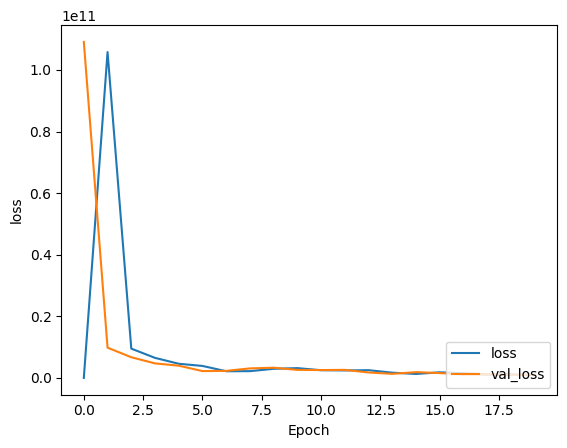

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right') # specify location of the legend

In [ ]:
model = create_mlp_model(720, 1280, 3, [128, 64, 16])
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(training_images, training_bounding_boxes, epochs=20, verbose=1, validation_split = 0.2, batch_size = 256)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right') # specify location of the legend

# CNN model

In [9]:
model = create_cnn_model(1280, 720, 3)
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(training_images, training_bounding_boxes, epochs=20, verbose=1, validation_split = 0.2, batch_size = 8)
model.save('CNN_1.h5')

Epoch 1/20
59/59 [==============================] - 56s 640ms/step - loss: 1366806.3750 - val_loss: 155520.4219
Epoch 2/20
59/59 [==============================] - 35s 592ms/step - loss: 152417.3594 - val_loss: 155508.8438
Epoch 3/20
59/59 [==============================] - 36s 606ms/step - loss: 152404.6250 - val_loss: 155495.1562
Epoch 4/20
59/59 [==============================] - 36s 604ms/step - loss: 152390.1250 - val_loss: 155479.5938
Epoch 5/20
59/59 [==============================] - 36s 604ms/step - loss: 152374.1406 - val_loss: 155463.1094
Epoch 6/20
59/59 [==============================] - 36s 605ms/step - loss: 152357.0625 - val_loss: 155445.3906
Epoch 7/20
59/59 [==============================] - 36s 605ms/step - loss: 152339.0312 - val_loss: 155427.0000
Epoch 8/20
59/59 [==============================] - 36s 606ms/step - loss: 152320.3125 - val_loss: 155407.8281
Epoch 9/20
59/59 [==============================] - 36s 605ms/step - loss: 152300.8125 - val_loss: 155388.0469


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


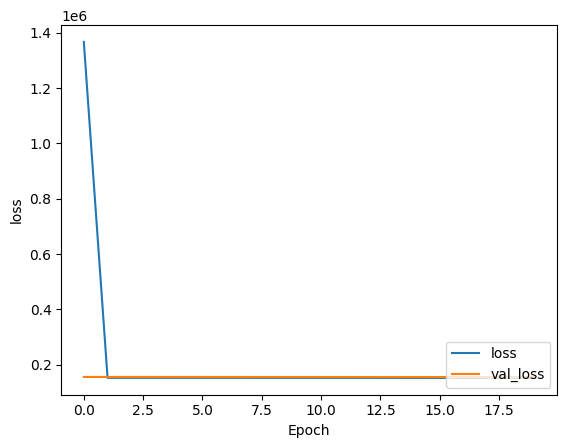

In [10]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right') # specify location of the legend

In [11]:
test_folder_path = "drive/MyDrive/FloW_IMG/FloW_IMG/test"
test_images, test_bounding_boxes = load_data(test_folder_path, 10, num_bounding_box_to_predict, desired_shape)
test_images = np.array(test_images)

training_bounding_boxes = np.array(test_bounding_boxes)
test_images_reshaped = np.reshape(test_images, (-1, 1280, 720, 3))

evaluation = model.evaluate(test_images_reshaped, test_bounding_boxes)
print(evaluation)
print(test_bounding_boxes)

1/1 [==============================] - 4s 4s/step - loss: 240452.9688
240452.96875
[[1067  420 1084  428  343  413  365  420  327  420  342  429    0    0
     0    0]
 [ 116  436  151  446  162  424  197  435 1084  422 1100  430    0    0
     0    0]
 [ 300  328  319  334  519  344  542  355  465  309  481  314    0    0
     0    0]
 [ 891  592  949  660    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 522  335  569  348  441  291  457  300  423  288  437  295    0    0
     0    0]
 [ 402  280  441  294  565  345  598  392  636  228  651  234    0    0
     0    0]
 [1016  325 1049  334    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 955  344 1045  375    0    0    0    0    0    0    0    0    0    0
     0    0]
 [1171  267 1200  278 1073  275 1105  285  798  300  849  316  942  264
   961  270]
 [1098  345 1198  375 1196  271 1220  290 1142  272 1167  279    0    0
     0    0]]


Visualise Images


In [15]:
!ls

CNN_1.h5  drive  sample_data


1/1 [==============================] - 0s 108ms/step
[[0.7022776  0.7798787  0.98160535 0.7123773 ]
 [1.0392555  0.47636798 0.8795279  0.64562905]
 [0.8046559  0.46275038 0.7122733  0.35806453]
 [0.39684117 0.50151306 0.8310492  0.26616746]]


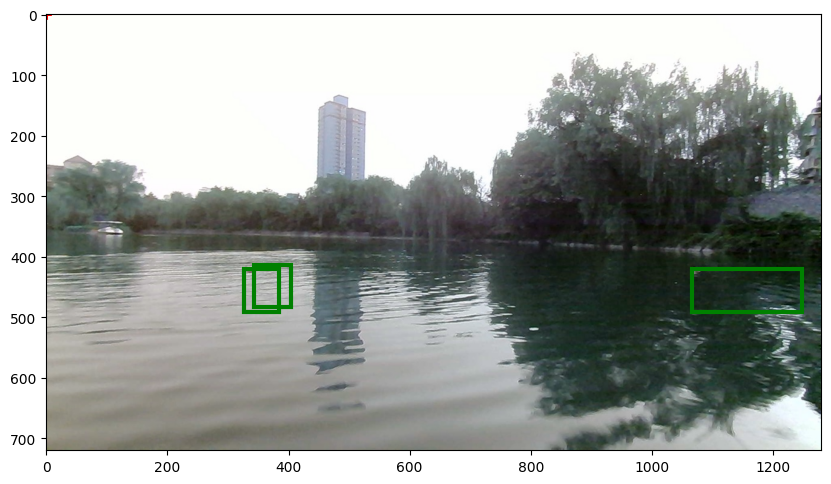

[[0.7022776  0.7798787  0.98160535 0.7123773 ]
 [1.0392555  0.47636798 0.8795279  0.64562905]
 [0.8046559  0.46275038 0.7122733  0.35806453]
 [0.39684117 0.50151306 0.8310492  0.26616746]]


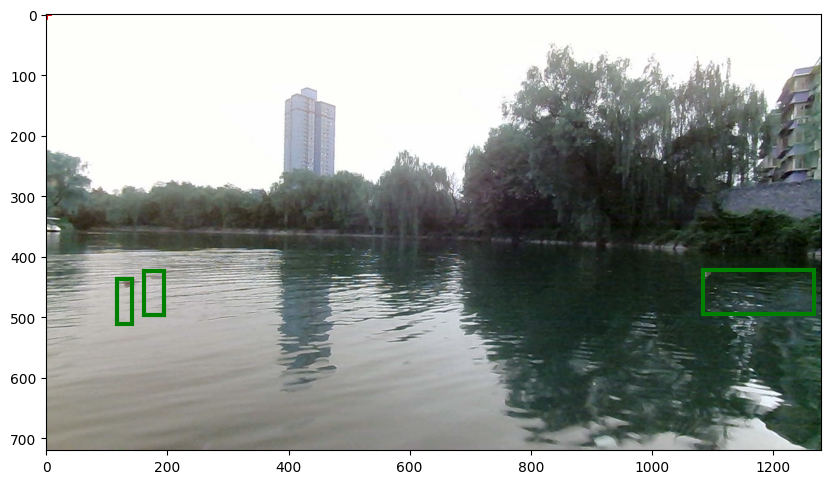

[[0.7022776  0.7798787  0.98160535 0.7123773 ]
 [1.0392555  0.47636798 0.8795279  0.64562905]
 [0.8046559  0.46275038 0.7122733  0.35806453]
 [0.39684117 0.50151306 0.8310492  0.26616746]]


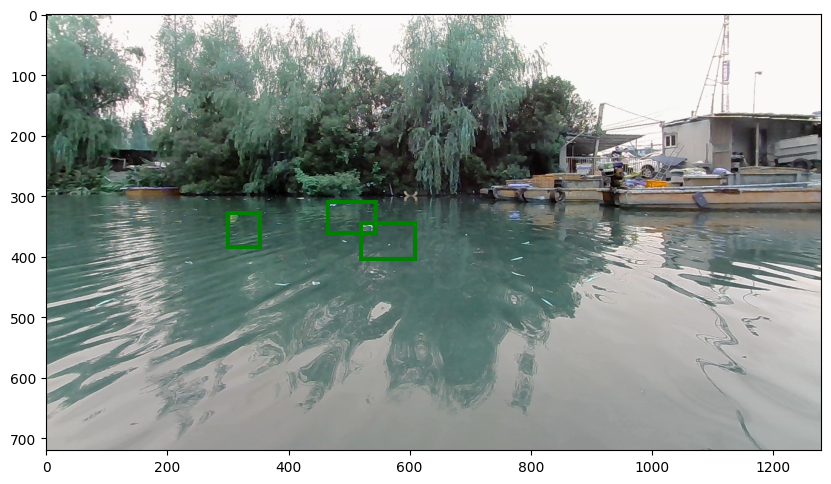

[[0.7022776  0.7798787  0.98160535 0.7123773 ]
 [1.0392555  0.47636798 0.8795279  0.64562905]
 [0.8046559  0.46275038 0.7122733  0.35806453]
 [0.39684117 0.50151306 0.8310492  0.26616746]]


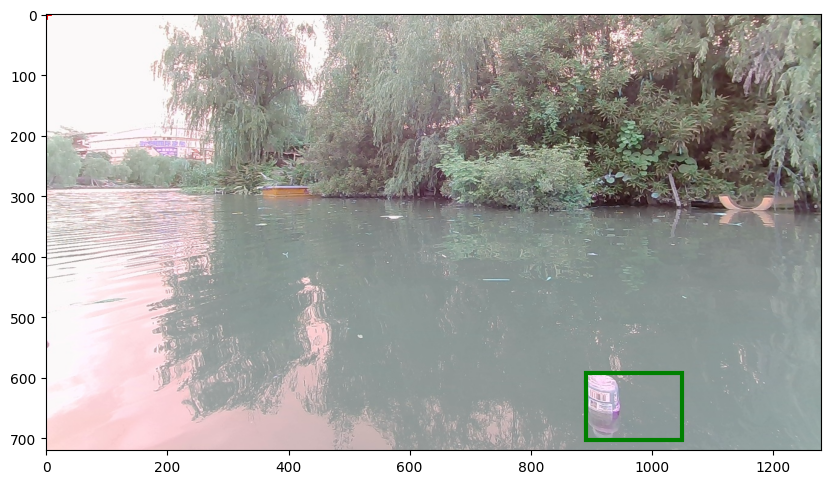

[[0.7022776  0.7798787  0.98160535 0.7123773 ]
 [1.0392555  0.47636798 0.8795279  0.64562905]
 [0.8046559  0.46275038 0.7122733  0.35806453]
 [0.39684117 0.50151306 0.8310492  0.26616746]]


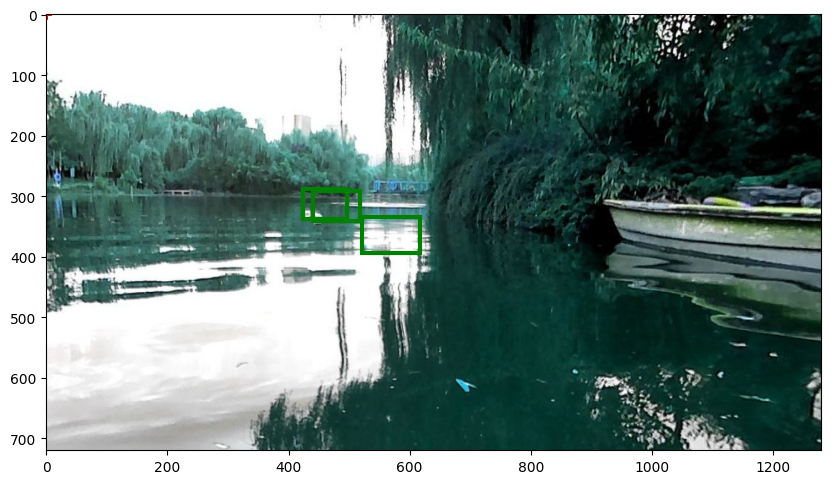

[[0.7022776  0.7798787  0.98160535 0.7123773 ]
 [1.0392555  0.47636798 0.8795279  0.64562905]
 [0.8046559  0.46275038 0.7122733  0.35806453]
 [0.39684117 0.50151306 0.8310492  0.26616746]]


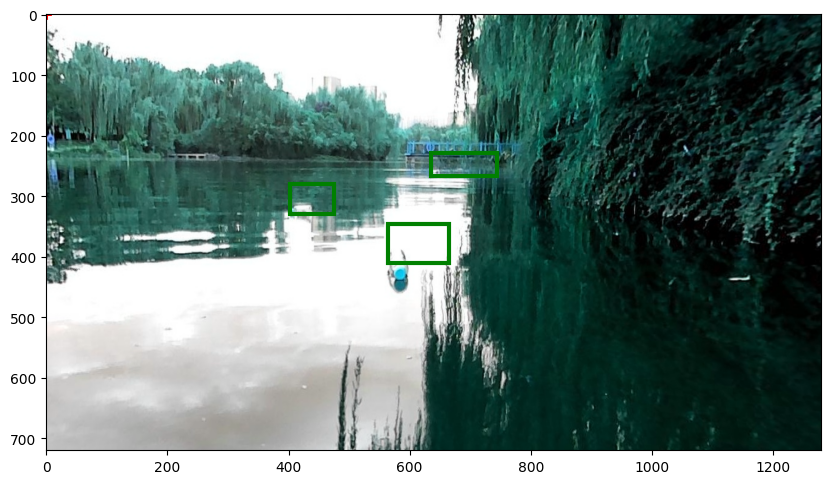

[[0.7022776  0.7798787  0.98160535 0.7123773 ]
 [1.0392555  0.47636798 0.8795279  0.64562905]
 [0.8046559  0.46275038 0.7122733  0.35806453]
 [0.39684117 0.50151306 0.8310492  0.26616746]]


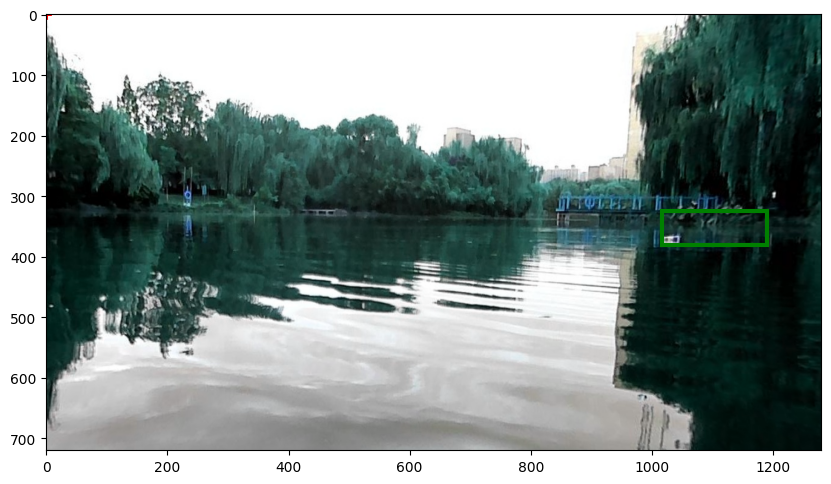

[[0.7022776  0.7798787  0.98160535 0.7123773 ]
 [1.0392555  0.47636798 0.8795279  0.64562905]
 [0.8046559  0.46275038 0.7122733  0.35806453]
 [0.39684117 0.50151306 0.8310492  0.26616746]]


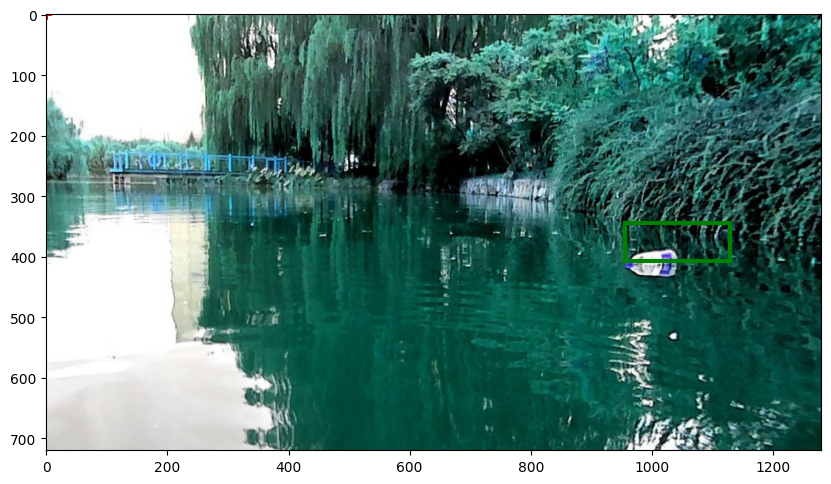

[[0.7022776  0.7798787  0.98160535 0.7123773 ]
 [1.0392555  0.47636798 0.8795279  0.64562905]
 [0.8046559  0.46275038 0.7122733  0.35806453]
 [0.39684117 0.50151306 0.8310492  0.26616746]]


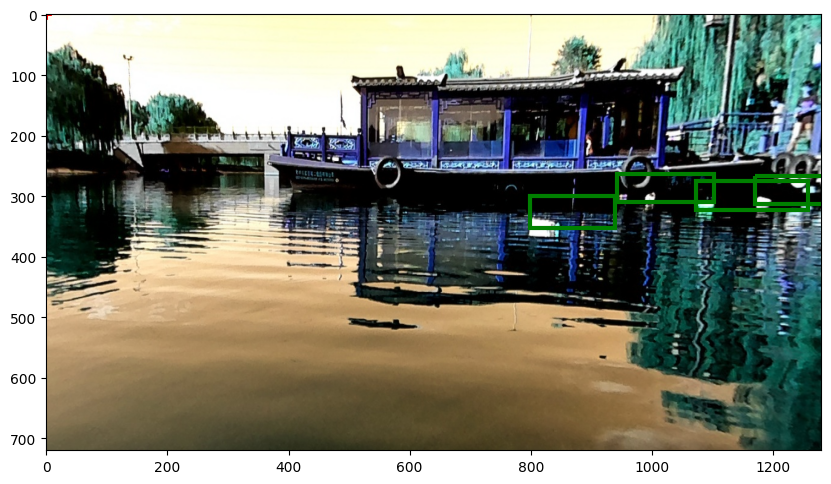

[[0.7022776  0.7798787  0.98160535 0.7123773 ]
 [1.0392555  0.47636798 0.8795279  0.64562905]
 [0.8046559  0.46275038 0.7122733  0.35806453]
 [0.39684117 0.50151306 0.8310492  0.26616746]]


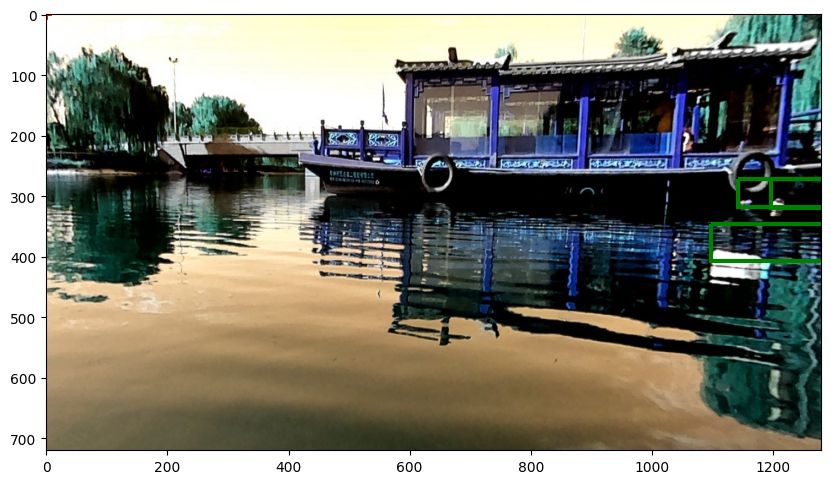

In [20]:
from matplotlib.patches import Rectangle

model = tf.keras.models.load_model("CNN_1.h5")


# Make predictions using the model
predictions = model.predict(test_images_reshaped)
num_images = len(test_images)
predictions = np.reshape(predictions, (num_images, num_bounding_box_to_predict, 4))
actual = np.reshape(test_bounding_boxes, (num_images, num_bounding_box_to_predict, 4))

for i in range(len(test_images)):
    image = test_images[i]

    # Create a subplot for each image
    plt.figure(figsize = (10,10))
    plt.imshow(image)
    print(predictions[i])
   # Extract and plot bounding boxes for this image
    for j in range(num_bounding_box_to_predict):
        x, y, width, height = predictions[i, j]

        # Create a Rectangle patch for the bounding box
        bbox = Rectangle((x, y), width, height, linewidth=7, edgecolor='r', facecolor='none')

        # Add the bounding box to the current subplot
        plt.gca().add_patch(bbox)

        x, y, width, height = actual[i, j]

        # Create a Rectangle patch for the bounding box
        bbox = Rectangle((x, y), width/6, height/6, linewidth=3, edgecolor='g', facecolor='none')

        # Add the bounding box to the current subplot
        plt.gca().add_patch(bbox)

    # Show the plot
    plt.show()

In [22]:
# Convert the model to a quantized TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_model = converter.convert()

# Save the quantized model to a .tflite file
with open("quantized_model.tflite", "wb") as f:
    f.write(quantized_model)



In [24]:
original_model_size = os.path.getsize("CNN_1.h5")
quantized_model_size = os.path.getsize("quantized_model.tflite")
print(f"Original Model Size: {original_model_size} bytes")
print(f"Quantized Model Size: {quantized_model_size} bytes")

change = ((quantized_model_size - original_model_size)/original_model_size)*100


print(change)

Original Model Size: 43126240 bytes
Quantized Model Size: 3599216 bytes
-91.65423185513043
